# Analysis across 50 world cities

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import planarity
import warnings
import matplotlib.pyplot as plt
from scipy import stats
from shapely import wkt
ox.config(use_cache=True)

In [2]:
df = pd.read_csv('data/results.csv', encoding='utf-8').drop('Unnamed: 0', axis=1)
df['geometry'] = df['geometry'].map(lambda x: wkt.loads(x))
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.crs = {'init': 'epsg:4326'}

In [3]:
gdf.head()

,city,count_cleaned_intersections,count_nonplanar_intersections,count_planar_intersections,country,distance,edge_length_ratio,geometry,is_planar,mean_edge_length,mean_planar_segment_length,network_type,nodes,overcount_nonplanar_cleaned,overcount_planar_cleaned,overcount_planar_nonplanar,phi,runtime
0,Buenos Aires,211,222,222,Argentina,805,1.000,POINT (-58.375547 -34.608657),True,111.152,111.151,drive,272,1.052,1.052,1.000,1.000,9.08
1,Buenos Aires,291,652,689,Argentina,805,0.947,POINT (-58.375547 -34.608657),False,55.278,52.375,walk,871,2.241,2.368,1.057,0.946,67.44
2,Sydney,151,177,239,Australia,805,0.749,POINT (151.208977 -33.863616),False,150.771,112.902,drive,223,1.172,1.583,1.350,0.741,5.79
3,Sydney,499,808,889,Australia,805,0.901,POINT (151.208977 -33.863616),False,53.459,48.141,walk,1018,1.619,1.782,1.100,0.909,81.50
4,Sao Paulo,288,330,417,Brazil,805,0.790,POINT (-46.6336 -23.549155),False,111.740,88.282,drive,415,1.146,1.448,1.264,0.791,15.17


In [4]:
# highest phi values
gdf[['city', 'phi']].sort_values(by='phi').head(10)

,city,phi
54,Moscow,0.574
84,Los Angeles,0.583
82,Dallas,0.598
86,Miami,0.647
15,Shanghai,0.670
14,Shanghai,0.682
70,Dubai,0.685
80,Cincinnati,0.730
94,Seattle,0.732
76,Atlanta,0.736


## map the results

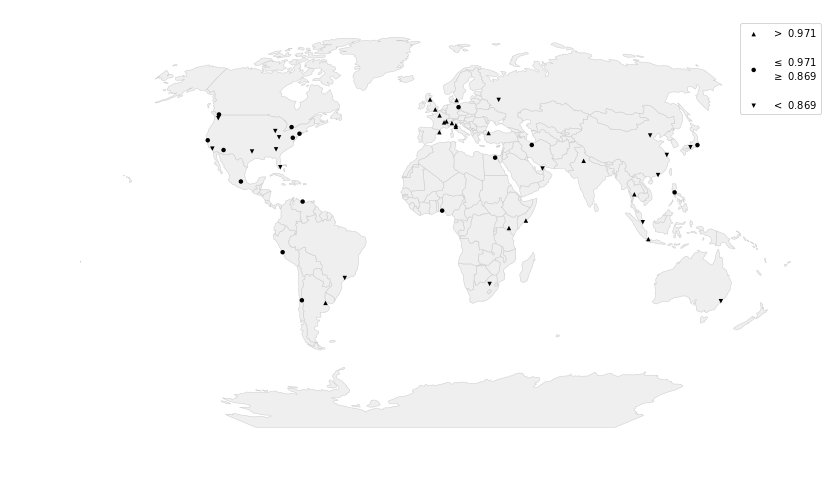

In [5]:
def get_marker(value, breaks):
    
    if value <= breaks[0]:
        return 1
    elif value <= breaks[1]:
        return 2
    else:
        return 3
    
drive = gdf[gdf['network_type']=='drive'].copy()
breaks = [drive['phi'].quantile(q=x) for x in (0.33, 0.67)]
drive['group'] = drive['phi'].apply(get_marker, breaks=breaks)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
crs_proj = '+proj=kav7'
world_proj = world.to_crs(crs_proj)
xmin, ymin, xmax, ymax = world_proj.unary_union.bounds
aspect_ratio = (xmax - xmin) / (ymax - ymin)
points_proj = drive.to_crs(crs_proj)

width = 14
fig, ax = plt.subplots(figsize=(width, width/aspect_ratio), facecolor='w')
ax = world_proj.plot(ax=ax, facecolor='#efefef', edgecolor='#cccccc', linewidth=0.5)

groups = []
points_proj[points_proj['group']==3].plot(ax=ax, marker='^', markersize=20, c='k', edgecolor='none', 
                                          label='$>$ {:.3f}'.format(breaks[1]))
points_proj[points_proj['group']==2].plot(ax=ax, marker='o', markersize=20, c='k', edgecolor='none', 
                                          label='\n$\leq$ {:.3f}\n$\geq$ {:.3f}\n'.format(breaks[1], breaks[0]))
points_proj[points_proj['group']==1].plot(ax=ax, marker='v', markersize=20, c='k', edgecolor='none', 
                                          label='$<$ {:.3f}'.format(breaks[0]))
    
plt.legend()

ax.axis('off')
fig.savefig('data/world_map_bw.png', dpi=300)
plt.show()

## regression analysis

drive r^2 = 0.980
walk r^2 = 0.994


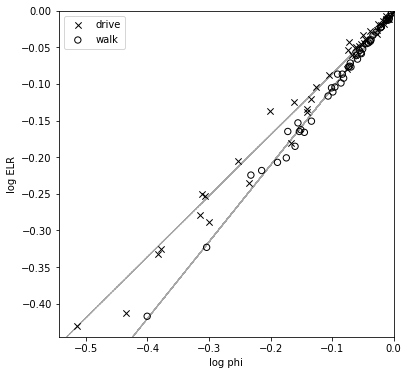

In [6]:
walk = gdf[gdf['network_type']=='walk']
drive = gdf[gdf['network_type']=='drive']

def transform(data):
    return np.log(data)

x = transform(gdf['phi'].copy())
y = transform(gdf['edge_length_ratio'].copy())
drive_x = transform(drive['phi'].copy())
drive_y = transform(drive['edge_length_ratio'].copy())
walk_x = transform(walk['phi'].copy())
walk_y = transform(walk['edge_length_ratio'].copy())

drive_slope, drive_intercept, drive_r_value, drive_p_value, drive_std_err = stats.linregress(drive_x, drive_y)
print('drive r^2 = {:.3f}'.format(drive_r_value ** 2))

walk_slope, walk_intercept, walk_r_value, walk_p_value, walk_std_err = stats.linregress(walk_x, walk_y)
print('walk r^2 = {:.3f}'.format(walk_r_value ** 2))

fig, ax = plt.subplots(figsize=(6,6))
drive_scatter = ax.scatter(x=drive_x, y=drive_y, c='k', edgecolor='none', s=40, linewidth=1, marker='x')
walk_scatter = ax.scatter(x=walk_x, y=walk_y, c='none', edgecolor='k', s=40, linewidth=1, marker='o')

# set x and y limits
x_min = x.min() * 0.98
x_max = x.max() * 1.02
y_min = y.min() * 0.98
y_max = y.max() * 1.02
ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

# create a line of best fit
x_line = x.copy()
x_line.loc[len(x_line)] = x_min
x_line.loc[len(x_line)] = x_max

drive_Y_est = x_line * drive_slope + drive_intercept
drive_line = ax.plot(x_line, drive_Y_est, c='k', alpha=0.35, linestyle=':', linewidth=1, zorder=-1)

walk_Y_est = x_line * walk_slope + walk_intercept
walk_line = ax.plot(x_line, walk_Y_est, c='k', alpha=0.35, linestyle='--', linewidth=1, zorder=-1)

ax.set_xlabel('log phi')
ax.set_ylabel('log ELR')
plt.legend([drive_scatter, walk_scatter], ['drive', 'walk'])

fig.savefig('data/regression_phi_split.png', dpi=300)
plt.show()

## make latex table

In [7]:
cols = ['country', 'city', 'network_type', 'is_planar', 'phi', 'edge_length_ratio']
table = gdf[cols].reindex(cols, axis=1).set_index(['country', 'city', 'network_type']).unstack(level=2)
table = table.swaplevel(i=0, j=1, axis=1)
table.columns = ['_'.join(col).strip() for col in table.columns]
table = table.rename(columns={'drive_edge_length_ratio' : 'd_ELR', 'drive_is_planar' : 'd_planar',
                      'drive_phi' : 'd_phi',
                      'walk_edge_length_ratio' : 'w_ELR', 'walk_is_planar' : 'w_planar',
                      'walk_phi' : 'w_phi'})
table = table.reindex(['d_planar', 'd_phi', 'd_ELR', 'w_planar', 'w_phi', 'w_ELR'], axis=1)
table['d_planar'] = table['d_planar'].map(lambda x: 'Yes' if x else 'No')
table['w_planar'] = table['w_planar'].map(lambda x: 'Yes' if x else 'No')
table

d_planar  d_phi  d_ELR w_planar  w_phi  w_ELR
country      city                                                       
Argentina    Buenos Aires       Yes  1.000  1.000       No  0.946  0.947
Australia    Sydney              No  0.741  0.749       No  0.909  0.901
Brazil       Sao Paulo           No  0.791  0.790       No  0.852  0.831
Canada       Toronto            Yes  0.930  0.958       No  0.858  0.848
             Vancouver           No  0.929  0.948       No  0.929  0.926
Chile        Santiago            No  0.875  0.887       No  0.972  0.971
China        Beijing             No  0.818  0.872       No  0.842  0.848
             Hong Kong           No  0.846  0.835       No  0.840  0.818
             Shanghai            No  0.682  0.717       No  0.670  0.659
Denmark      Copenhagen         Yes  0.992  0.988       No  0.991  0.987
Egypt        Cairo               No  0.900  0.916       No  0.918  0.906
France       Lyon                No  0.991  0.989       No  0.960  0.957
             Paris               No  0.988  0.993       No  0.920  0.917
Germany      Berlin              No  0.939  0.950       No  0.943  0.936
India        Delhi              Yes  1.000  1.000      Yes  0.993  0.992
Indonesia    Jakarta            Yes  0.983  0.986       No  0.962  0.960
Iran         Tehran              No  0.962  0.973       No  0.957  0.956
Italy        Bologna            Yes  1.000  1.000      Yes  0.996  0.996
             Florence           Yes  1.000  1.000       No  0.980  0.978
             Milan              Yes  1.000  1.000       No  0.875  0.860
Japan        Osaka               No  0.868  0.871       No  0.951  0.949
             Tokyo               No  0.927  0.923       No  0.922  0.912
Kenya        Nairobi             No  0.974  0.974       No  0.949  0.943
Mexico       Mexico City         No  0.940  0.952       No  0.913  0.917
Nigeria      Lagos               No  0.952  0.967       No  0.988  0.987
Peru         Lima                No  0.939  0.941       No  0.932  0.931
Philippines  Manila              No  0.946  0.953       No  0.906  0.895
Russia       Moscow              No  0.574  0.680       No  0.856  0.858
Singapore    Singapore           No  0.868  0.874       No  0.899  0.890
Somalia      Mogadishu          Yes  1.000  1.000      Yes  1.000  1.000
South Africa Johannesburg        No  0.851  0.883       No  0.997  0.997
Spain        Barcelona          Yes  1.000  1.000       No  0.904  0.900
Switzerland  Geneva              No  0.985  0.982       No  0.828  0.813
Thailand     Bangkok             No  0.988  0.988       No  0.993  0.989
Turkey       Istanbul            No  0.975  0.982       No  0.980  0.978
UAE          Dubai               No  0.685  0.722       No  0.860  0.850
UK           Edinburgh           No  0.973  0.968       No  0.988  0.988
             London              No  0.979  0.981       No  0.865  0.847
USA          Atlanta             No  0.736  0.777       No  0.738  0.724
             Chicago             No  0.776  0.814       No  0.807  0.804
             Cincinnati          No  0.730  0.757       No  0.931  0.927
             Dallas              No  0.598  0.650      Yes  0.963  0.959
             Los Angeles         No  0.583  0.635       No  0.793  0.799
             Miami               No  0.647  0.662       No  0.964  0.961
             New York            No  0.881  0.901       No  0.942  0.941
             Phoenix             No  0.955  0.962       No  0.979  0.977
             San Francisco       No  0.935  0.941       No  0.948  0.944
             Seattle             No  0.732  0.779       No  0.933  0.926
             Washington DC       No  0.948  0.956       No  0.967  0.967
Venezuela    Caracas             No  0.953  0.957      Yes  1.000  1.000

In [8]:
print(table.to_latex())

\begin{tabular}{lllrrlrr}
\toprule
          &         & d\_planar &  d\_phi &  d\_ELR & w\_planar &  w\_phi &  w\_ELR \\
country & city &          &        &        &          &        &        \\
\midrule
Argentina & Buenos Aires &      Yes &  1.000 &  1.000 &       No &  0.946 &  0.947 \\
Australia & Sydney &       No &  0.741 &  0.749 &       No &  0.909 &  0.901 \\
Brazil & Sao Paulo &       No &  0.791 &  0.790 &       No &  0.852 &  0.831 \\
Canada & Toronto &      Yes &  0.930 &  0.958 &       No &  0.858 &  0.848 \\
          & Vancouver &       No &  0.929 &  0.948 &       No &  0.929 &  0.926 \\
Chile & Santiago &       No &  0.875 &  0.887 &       No &  0.972 &  0.971 \\
China & Beijing &       No &  0.818 &  0.872 &       No &  0.842 &  0.848 \\
          & Hong Kong &       No &  0.846 &  0.835 &       No &  0.840 &  0.818 \\
          & Shanghai &       No &  0.682 &  0.717 &       No &  0.670 &  0.659 \\
Denmark & Copenhagen &      Yes &  0.992 &  0.988 &       No &  0.

# More detailed summary statistics

In [9]:
walk = pd.read_csv('data/results_walk.csv')
drive = pd.read_csv('data/results_drive.csv')

In [10]:
walk.columns

Index(['country', 'city', 'distance', 'network_type',
       'count_cleaned_intersections', 'count_nonplanar_intersections',
       'count_planar_intersections', 'edge_length_ratio', 'geometry',
       'is_planar', 'mean_edge_length', 'mean_planar_segment_length', 'nodes',
       'overcount_nonplanar_cleaned', 'overcount_planar_cleaned',
       'overcount_planar_nonplanar', 'phi', 'runtime'],
      dtype='object')

In [11]:
print(drive['is_planar'].sum() / len(walk))
print(drive['phi'].mean())
print(drive['phi'].min())
print(drive['phi'].max())
print(drive['edge_length_ratio'].mean())
print(drive['edge_length_ratio'].min())
print(drive['edge_length_ratio'].max())
print((drive['phi']==1).sum())
print((drive['edge_length_ratio']==1).sum())

0.2
0.8853000000000002
0.574
1.0
0.8996599999999999
0.635
1.0
7
7


In [12]:
print(walk['is_planar'].sum() / len(walk))
print(walk['phi'].mean())
print(walk['phi'].min())
print(walk['phi'].max())
print(walk['edge_length_ratio'].mean())
print(walk['edge_length_ratio'].min())
print(walk['edge_length_ratio'].max())
print((walk['phi']==1).sum())
print((walk['edge_length_ratio']==1).sum())

0.1
0.92018
0.67
1.0
0.91534
0.659
1.0
2
2


In [13]:
drive.sort_values('phi', ascending=True)

,country,city,distance,network_type,count_cleaned_intersections,count_nonplanar_intersections,count_planar_intersections,edge_length_ratio,geometry,is_planar,mean_edge_length,mean_planar_segment_length,nodes,overcount_nonplanar_cleaned,overcount_planar_cleaned,overcount_planar_nonplanar,phi,runtime
27,Russia,Moscow,805,drive,59,70,122,0.680,POINT (37.537873 55.749165),False,246.170,167.467,110,1.186,2.068,1.743,0.574,2.04
42,USA,Los Angeles,805,drive,162,180,309,0.635,POINT (-118.249837 34.056394),False,160.775,102.159,251,1.111,1.907,1.717,0.583,7.72
41,USA,Dallas,805,drive,228,299,500,0.650,POINT (-96.805628 32.777714),False,135.710,88.197,378,1.311,2.193,1.672,0.598,14.88
43,USA,Miami,805,drive,185,220,340,0.662,POINT (-80.19443199999999 25.7725),False,124.681,82.503,283,1.189,1.838,1.545,0.647,8.39
7,China,Shanghai,805,drive,109,176,258,0.717,POINT (121.503787 31.236286),False,161.564,115.896,215,1.615,2.367,1.466,0.682,5.29
35,UAE,Dubai,805,drive,152,198,289,0.722,POINT (55.274985 25.202671),False,165.494,119.522,243,1.303,1.901,1.460,0.685,5.89
40,USA,Cincinnati,805,drive,213,243,333,0.757,POINT (-84.514753 39.101593),False,134.080,101.477,313,1.141,1.563,1.370,0.730,10.82
47,USA,Seattle,805,drive,258,270,369,0.779,POINT (-122.33445 47.61117),False,113.763,88.615,350,1.047,1.430,1.367,0.732,15.46
38,USA,Atlanta,805,drive,190,198,269,0.777,POINT (-84.386107 33.756297),False,130.952,101.793,255,1.042,1.416,1.359,0.736,8.19
1,Australia,Sydney,805,drive,151,177,239,0.749,POINT (151.208977 -33.863616),False,150.771,112.902,223,1.172,1.583,1.350,0.741,5.79


In [14]:
drive[drive['is_planar'] == True].sort_values('phi')[['city', 'phi', 'edge_length_ratio']]

,city,phi,edge_length_ratio
3,Toronto,0.930,0.958
15,Jakarta,0.983,0.986
9,Copenhagen,0.992,0.988
0,Buenos Aires,1.000,1.000
14,Delhi,1.000,1.000
17,Bologna,1.000,1.000
18,Florence,1.000,1.000
19,Milan,1.000,1.000
29,Mogadishu,1.000,1.000
31,Barcelona,1.000,1.000


In [15]:
walk[walk['is_planar'] == True].sort_values('phi')[['city', 'phi', 'edge_length_ratio']]

,city,phi,edge_length_ratio
41,Dallas,0.963,0.959
14,Delhi,0.993,0.992
17,Bologna,0.996,0.996
29,Mogadishu,1.000,1.000
49,Caracas,1.000,1.000


In [16]:
drive['drive_walk_phi'] = (walk['phi'] / drive['phi'])
drive[['city', 'drive_walk_phi']].sort_values('drive_walk_phi')

,city,drive_walk_phi
32,Geneva,0.840609
19,Milan,0.875000
37,London,0.883555
31,Barcelona,0.904000
3,Toronto,0.922581
12,Paris,0.931174
0,Buenos Aires,0.946000
26,Manila,0.957717
11,Lyon,0.968718
23,Mexico City,0.971277


In [17]:
print(drive['overcount_planar_nonplanar'].mean())
print(1 - drive['edge_length_ratio'].mean())
print(walk['overcount_planar_nonplanar'].mean())
print(1 - walk['edge_length_ratio'].mean())

1.15688
0.1003400000000001
1.09402
0.08465999999999996


True


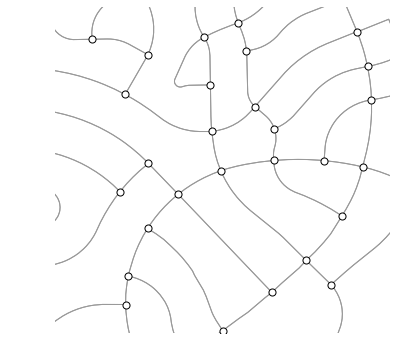

In [18]:
pt = (38.586683, -121.375365)
dist = 500

G = ox.graph_from_point(pt, network_type='drive', distance=dist*2, truncate_by_edge=True)
G = ox.project_graph(G)

warnings.filterwarnings(action='ignore')
print(planarity.is_planar(G))
warnings.filterwarnings(action='default')

bbox = ox.bbox_from_point(pt, dist, project_utm=True)
fig, ax = ox.plot_graph(G, bbox=bbox, fig_height=6, fig_width=6, 
                        node_size=50, node_zorder=2, node_color='w', node_edgecolor='k',
                        save=True, filename='planar')

False


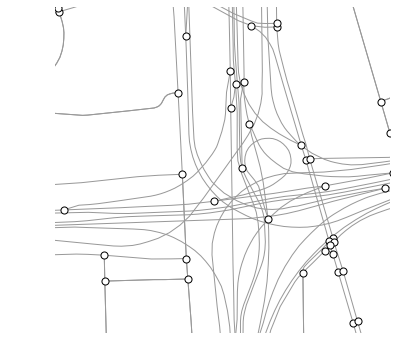

In [19]:
pt = (32.909035, -96.898432)
G = ox.graph_from_point(pt, network_type='drive', distance=dist*2, truncate_by_edge=True)
G = ox.project_graph(G)

warnings.filterwarnings(action='ignore')
print(planarity.is_planar(G))
warnings.filterwarnings(action='default')

bbox = ox.bbox_from_point(pt, dist, project_utm=True)
fig, ax = ox.plot_graph(G, bbox=bbox, fig_height=6, fig_width=6, 
                        node_size=50, node_zorder=2, node_color='w', node_edgecolor='k',
                        save=True, filename='nonplanar')

# Single city analysis

In [20]:
df = pd.read_csv('data/city_samples.csv').drop('Unnamed: 0', axis=1)
df.head()

,coords,count_cleaned_intersections,count_nonplanar_intersections,count_planar_intersections,distance,edge_length_ratio,is_planar,mean_edge_length,mean_planar_segment_length,name,network_type,nodes,overcount_nonplanar_cleaned,overcount_planar_cleaned,overcount_planar_nonplanar,runtime
0,"(37.81457038291894, -122.25529153926769)",205,247,282,805,0.897944,False,117.800819,105.778526,"00_Oakland, California, USA",drive,303,1.204878,1.375610,1.141700,10.597374
1,"(37.80568383476944, -122.25476751037529)",165,196,200,805,0.981087,True,107.673318,105.636841,"01_Oakland, California, USA",drive,261,1.187879,1.212121,1.020408,7.418982
2,"(37.807481931575765, -122.28028026741039)",229,288,363,805,0.839747,False,112.620406,94.572611,"02_Oakland, California, USA",drive,353,1.257642,1.585153,1.260417,13.964599
3,"(37.80936423077242, -122.2137352007491)",146,162,162,805,0.999988,True,144.199748,144.198053,"04_Oakland, California, USA",drive,225,1.109589,1.109589,1.000000,6.135225
4,"(37.737072168646584, -122.18838543235465)",140,160,174,805,0.958176,False,132.834136,127.278440,"05_Oakland, California, USA",drive,226,1.142857,1.242857,1.087500,5.117002


In [21]:
df['overcount_planar_nonplanar'].mean()

1.0886519002475272

In [22]:
df['phi'] = 1 / df['overcount_planar_nonplanar']
cols = ['phi', 'edge_length_ratio']
df2 = df[cols].copy().head(100)
table = df2[cols].describe().round(3)
table = table.loc[['mean', 'std', 'min', 'max']]
table

,phi,edge_length_ratio
mean,0.930,0.947
std,0.101,0.082
min,0.569,0.637
max,1.000,1.000


In [23]:
print(table.to_latex())

\begin{tabular}{lrr}
\toprule
{} &    phi &  edge\_length\_ratio \\
\midrule
mean &  0.930 &              0.947 \\
std  &  0.101 &              0.082 \\
min  &  0.569 &              0.637 \\
max  &  1.000 &              1.000 \\
\bottomrule
\end{tabular}



In [24]:
df.head(100)['is_planar'].value_counts()

True     67
False    33
Name: is_planar, dtype: int64

In [25]:
len(df.head(100)[df.head(100)['overcount_planar_nonplanar'] > 1])

63